In [1]:
import os
import sys
import os.path
import cv2
import math
import numpy as np
from PIL import Image 
import os 
from pathlib import Path
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score
import pydicom
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import os
import time
import numpy as np
import cv2
import numpy as np
import imageio
import numpy as np
# sys.path.insert(0, '../src')
from scipy.fftpack import fft2, ifft2, fftshift
import imageio
# import src.utils as pu
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.segmentation import clear_border
from skimage.morphology import label
import logging

In [12]:
from collections import OrderedDict, defaultdict

def normalize(min_old, max_old, min_new, max_new, val):
	'''Normalizes values to the interval [min_new, max_new]
	Parameters:
		min_old: min value from old base.
		max_old: max value from old base.
		min_new: min value from new base.
		max_new: max value from new base.
		val: float or array-like value to be normalized.
	'''

	ratio = (val - min_old) / (max_old - min_old)
	normalized = (max_new - min_new) * ratio + min_new
	return normalized.astype(np.uint8)

def histogram(data):
	'''Generates the histogram for the given data.
	Parameters:
		data: data to make the histogram.
	Returns: histogram, bins.
	'''

	pixels, count = np.unique(data, return_counts=True)
	hist = OrderedDict()

	for i in range(len(pixels)):
		hist[pixels[i]] = count[i]

	return np.array(list(hist.values())), np.array(list(hist.keys()))

def to_grayscale(image):
	red_v = image[:, :, 0] * 0.299
	green_v = image[:, :, 1] * 0.587
	blue_v = image[:, :, 2] * 0.144
	image = red_v + green_v + blue_v

	return image.astype(np.uint8)

def clip_histogram(hist, bins, clip_limit):
	'''Clips the given histogram.
	Parameters:
		hist: frequencies of each pixel.
		bins: pixels.
		clip_limit: limit to pixel frequencies.
	Returns the clipped hist.
	'''

	n_bins = len(bins)

	# Removing values above clip_limit
	excess = 0
	for i in range(n_bins):
		if hist[i] > clip_limit:
			excess += hist[i] - clip_limit
			hist[i] = clip_limit

	## Redistributing exceding values ##
	# Calculating the values to be put on all bins
	for_each_bin = excess // n_bins
	# Calculating the values left
	leftover = excess % n_bins

	hist += for_each_bin
	for i in range(leftover):
		hist[i] += 1

	return hist

def calculate_cdf(hist, bins):
	'''Calculates the normalized CDF (Cumulative Distribution Function)
	for the histogram.
	Parameters:
		hist: frequencies of each pixel.
		bins: pixels.
	Returns the CDF in a dictionary.
	'''

	# Calculating probability for each pixel
	pixel_probability = hist / hist.sum()
	# Calculating the CDF (Cumulative Distribution Function)
	cdf = np.cumsum(pixel_probability)

	cdf_normalized = cdf * 255

	hist_eq = {}
	for i in range(len(cdf)):
		hist_eq[bins[i]] = int(cdf_normalized[i])

	return hist_eq

In [13]:
class HEF:
    def __init__(self, filename, results_path):
        self.filename = filename
        self.get_input()
        self.results_path = results_path

    def get_input(self):
        print(
            "Select D0 value for High cut (1 to 90): ")
        self.d0v = 5
        assert 1 <= self.d0v <= 90

    def run(self):
        '''Runs the algorithm for the image.'''
        image = imageio.imread(self.filename)

        if len(image.shape) == 3:
            img_grayscale = to_grayscale(image)
        else:
            img_grayscale=image
        img = normalize(np.min(img_grayscale), np.max(image), 0, 255,
                                        img_grayscale)
        # HF part
        img_fft = fft2(img)  # img after fourier transformation
        img_sfft = fftshift(img_fft)  # img after shifting component to the center

        m, n = img_sfft.shape
        filter_array = np.zeros((m, n))

        for i in range(m):
            for j in range(n):
                filter_array[i, j] = 1.0 - np.exp(- ((i-m / 2.0) ** 2 + (j-n / 2.0) ** 2) / (2 * (self.d0v ** 2)))
        k1 = 0.5
        k2 = 0.75
        high_filter = k1 + k2*filter_array

        img_filtered = high_filter * img_sfft
        img_hef = np.real(ifft2(fftshift(img_filtered)))  # HFE filtering done

        return img_hef

In [14]:
def convert(image_dir, output_home, limit=None):
    i = 1
    list = os.listdir(image_dir)
    file_count = len(list)
    for f in list:
        if ("ppm" not in f) and ('png' not in f):
            continue
        if i >= file_count:
            break
        print(i)
        i += 1
        print("processing: %s" % (f))
        
        image_path = os.path.join(image_dir, f)
        img = cv2.imread(image_path)[:, :, 0]
        homo_filter = HEF(image_path,output_home)
        img_filtered = homo_filter.run()
        basename = os.path.basename(image_dir)
        output_dir = os.path.join(output_home, basename)
        
        
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)
        output_file = os.path.join(output_dir, f)
        cv2.imwrite(output_file, img_filtered)

In [15]:
import cv2
    
input_home_dir = "E:/TrainingImages/"
output_home_dir = "E:/enhance/TrainingImagesHDF/"
limit = 2.0
    
list_dir = os.listdir(input_home_dir)
convert(input_home_dir, output_home_dir, limit=limit)

1
processing: 1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258.png
Select D0 value for High cut (1 to 90): 
2
processing: 1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125.png
Select D0 value for High cut (1 to 90): 
3
processing: 1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162.png
Select D0 value for High cut (1 to 90): 
4
processing: 1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257.png
Select D0 value for High cut (1 to 90): 
5
processing: 1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016.png
Select D0 value for High cut (1 to 90): 
6
processing: 1.2.826.0.1.3680043.8.498.10053755320637729867508668285241208441.png
Select D0 value for High cut (1 to 90): 
7
processing: 1.2.826.0.1.3680043.8.498.10062189329714053601496804394945741428.png
Select D0 value for High cut (1 to 90): 
8
processing: 1.2.826.0.1.3680043.8.498.10065930002825553435161793347987832017.png
Select D0 value for High cut (1 to 90): 
9
proces

Select D0 value for High cut (1 to 90): 
67
processing: 1.2.826.0.1.3680043.8.498.10559597880824002291392101824679235791.png
Select D0 value for High cut (1 to 90): 
68
processing: 1.2.826.0.1.3680043.8.498.10561448436484761386439086564417613479.png
Select D0 value for High cut (1 to 90): 
69
processing: 1.2.826.0.1.3680043.8.498.10576209690457979230463217120341684832.png
Select D0 value for High cut (1 to 90): 
70
processing: 1.2.826.0.1.3680043.8.498.10588106614996547009381439874146181339.png
Select D0 value for High cut (1 to 90): 
71
processing: 1.2.826.0.1.3680043.8.498.10592554496378195625542895470016545916.png
Select D0 value for High cut (1 to 90): 
72
processing: 1.2.826.0.1.3680043.8.498.10600863545745511259205283184658922580.png
Select D0 value for High cut (1 to 90): 
73
processing: 1.2.826.0.1.3680043.8.498.10603862758592967408863259452643881675.png
Select D0 value for High cut (1 to 90): 
74
processing: 1.2.826.0.1.3680043.8.498.10606529710873585120949488696315239902.png


132
processing: 1.2.826.0.1.3680043.8.498.11110211547314206547056925742174931713.png
Select D0 value for High cut (1 to 90): 
133
processing: 1.2.826.0.1.3680043.8.498.11121020226184051416110461667223845149.png
Select D0 value for High cut (1 to 90): 
134
processing: 1.2.826.0.1.3680043.8.498.11121185482084353409350327062409243101.png
Select D0 value for High cut (1 to 90): 
135
processing: 1.2.826.0.1.3680043.8.498.11122239040519216689582738524886184394.png
Select D0 value for High cut (1 to 90): 
136
processing: 1.2.826.0.1.3680043.8.498.11134132044055149977462420371171044125.png
Select D0 value for High cut (1 to 90): 
137
processing: 1.2.826.0.1.3680043.8.498.11142749741335643457785031950275730958.png
Select D0 value for High cut (1 to 90): 
138
processing: 1.2.826.0.1.3680043.8.498.11143809892724802682269433779504237349.png
Select D0 value for High cut (1 to 90): 
139
processing: 1.2.826.0.1.3680043.8.498.11154819012720659139394406394594718465.png
Select D0 value for High cut (1 t

198
processing: 1.2.826.0.1.3680043.8.498.11578613116828745425553779031202532310.png
Select D0 value for High cut (1 to 90): 
199
processing: 1.2.826.0.1.3680043.8.498.11583449165849197381539073980360763039.png
Select D0 value for High cut (1 to 90): 
200
processing: 1.2.826.0.1.3680043.8.498.11585588613483959369792983655058647666.png
Select D0 value for High cut (1 to 90): 
201
processing: 1.2.826.0.1.3680043.8.498.11592311198629503991670907181209693809.png
Select D0 value for High cut (1 to 90): 
202
processing: 1.2.826.0.1.3680043.8.498.11594460919874020693074059465211127073.png
Select D0 value for High cut (1 to 90): 
203
processing: 1.2.826.0.1.3680043.8.498.11609569886309883029089958702332731827.png
Select D0 value for High cut (1 to 90): 
204
processing: 1.2.826.0.1.3680043.8.498.11645569277779410720325219642567208190.png
Select D0 value for High cut (1 to 90): 
205
processing: 1.2.826.0.1.3680043.8.498.11648397737056426121684282413964407685.png
Select D0 value for High cut (1 t

Select D0 value for High cut (1 to 90): 
264
processing: 1.2.826.0.1.3680043.8.498.12037310414443283406211198353885205904.png
Select D0 value for High cut (1 to 90): 
265
processing: 1.2.826.0.1.3680043.8.498.12038572537031811246404832851090645778.png
Select D0 value for High cut (1 to 90): 
266
processing: 1.2.826.0.1.3680043.8.498.12040039356501140708409183643375906784.png
Select D0 value for High cut (1 to 90): 
267
processing: 1.2.826.0.1.3680043.8.498.12056946449382353884458675177339782144.png
Select D0 value for High cut (1 to 90): 
268
processing: 1.2.826.0.1.3680043.8.498.12063258080118904000188967574141867069.png
Select D0 value for High cut (1 to 90): 
269
processing: 1.2.826.0.1.3680043.8.498.12095888743668316699586184536021082509.png
Select D0 value for High cut (1 to 90): 
270
processing: 1.2.826.0.1.3680043.8.498.12108345996741935961150497389670692158.png
Select D0 value for High cut (1 to 90): 
271
processing: 1.2.826.0.1.3680043.8.498.12115211226207465067894867083043839

329
processing: 1.2.826.0.1.3680043.8.498.12505594116192250242982710363687666461.png
Select D0 value for High cut (1 to 90): 
330
processing: 1.2.826.0.1.3680043.8.498.12508457306413949046355947367228996515.png
Select D0 value for High cut (1 to 90): 
331
processing: 1.2.826.0.1.3680043.8.498.12516034995064011638885116460482962933.png
Select D0 value for High cut (1 to 90): 
332
processing: 1.2.826.0.1.3680043.8.498.12519421941347857414117635998246747858.png
Select D0 value for High cut (1 to 90): 
333
processing: 1.2.826.0.1.3680043.8.498.12527966255170548734423232195449414334.png
Select D0 value for High cut (1 to 90): 
334
processing: 1.2.826.0.1.3680043.8.498.12529523974665777310068038344135596371.png
Select D0 value for High cut (1 to 90): 
335
processing: 1.2.826.0.1.3680043.8.498.12531147140263297225126104319831442489.png
Select D0 value for High cut (1 to 90): 
336
processing: 1.2.826.0.1.3680043.8.498.12531481447834027727516857714539413118.png
Select D0 value for High cut (1 t

Select D0 value for High cut (1 to 90): 
395
processing: 1.2.826.0.1.3680043.8.498.13032367994874438756820688042868936237.png
Select D0 value for High cut (1 to 90): 
396
processing: 1.2.826.0.1.3680043.8.498.13036023923775826702016954470316567047.png
Select D0 value for High cut (1 to 90): 
397
processing: 1.2.826.0.1.3680043.8.498.13045859977087867316570896465209261998.png
Select D0 value for High cut (1 to 90): 
398
processing: 1.2.826.0.1.3680043.8.498.13047212791447150993221020624935527324.png
Select D0 value for High cut (1 to 90): 
399
processing: 1.2.826.0.1.3680043.8.498.13051952565942645231581800734633121489.png
Select D0 value for High cut (1 to 90): 
400
processing: 1.2.826.0.1.3680043.8.498.13066708512134387718179717660802975137.png
Select D0 value for High cut (1 to 90): 
401
processing: 1.2.826.0.1.3680043.8.498.13070896846370726422343092960399298584.png
Select D0 value for High cut (1 to 90): 
402
processing: 1.2.826.0.1.3680043.8.498.13075912157260714679495702821878469

460
processing: 1.2.826.0.1.3680043.8.498.14866964978126122163136289081267137606.png
Select D0 value for High cut (1 to 90): 
461
processing: 1.2.826.0.1.3680043.8.498.14870104865293405748740118384182082089.png
Select D0 value for High cut (1 to 90): 
462
processing: 1.2.826.0.1.3680043.8.498.15057304241493848725568511971316122720.png
Select D0 value for High cut (1 to 90): 
463
processing: 1.2.826.0.1.3680043.8.498.15092989485256748181328412427295059067.png
Select D0 value for High cut (1 to 90): 
464
processing: 1.2.826.0.1.3680043.8.498.15126022716559326221899996790039127181.png
Select D0 value for High cut (1 to 90): 
465
processing: 1.2.826.0.1.3680043.8.498.15144815417970827102709069064050334659.png
Select D0 value for High cut (1 to 90): 
466
processing: 1.2.826.0.1.3680043.8.498.15546680820535281934215259494310335138.png
Select D0 value for High cut (1 to 90): 
467
processing: 1.2.826.0.1.3680043.8.498.15590548900176442928310981574028424628.png
Select D0 value for High cut (1 t

Select D0 value for High cut (1 to 90): 
526
processing: 1.2.826.0.1.3680043.8.498.19334364457389757316612393684246576894.png
Select D0 value for High cut (1 to 90): 
527
processing: 1.2.826.0.1.3680043.8.498.19460762441089929612901354084427584691.png
Select D0 value for High cut (1 to 90): 
528
processing: 1.2.826.0.1.3680043.8.498.19492460680304470580481294083656750366.png
Select D0 value for High cut (1 to 90): 
529
processing: 1.2.826.0.1.3680043.8.498.19650035668800346959048957101834990627.png
Select D0 value for High cut (1 to 90): 
530
processing: 1.2.826.0.1.3680043.8.498.19712457668194559953952352981155784971.png
Select D0 value for High cut (1 to 90): 
531
processing: 1.2.826.0.1.3680043.8.498.19721119621238043697657706477588147207.png
Select D0 value for High cut (1 to 90): 
532
processing: 1.2.826.0.1.3680043.8.498.19799270208005490037950033399456094069.png
Select D0 value for High cut (1 to 90): 
533
processing: 1.2.826.0.1.3680043.8.498.19849231296262783830768380963359737

591
processing: 1.2.826.0.1.3680043.8.498.23220876608200585321915364568900947132.png
Select D0 value for High cut (1 to 90): 
592
processing: 1.2.826.0.1.3680043.8.498.23278875712422646971691508356466872951.png
Select D0 value for High cut (1 to 90): 
593
processing: 1.2.826.0.1.3680043.8.498.23308664237525249659606665284289182621.png
Select D0 value for High cut (1 to 90): 
594
processing: 1.2.826.0.1.3680043.8.498.23326118276117176550489242246040300667.png
Select D0 value for High cut (1 to 90): 
595
processing: 1.2.826.0.1.3680043.8.498.23423438818539975807723199585789964264.png
Select D0 value for High cut (1 to 90): 
596
processing: 1.2.826.0.1.3680043.8.498.23454375140912819740975435771767412101.png
Select D0 value for High cut (1 to 90): 
597
processing: 1.2.826.0.1.3680043.8.498.23524701560696449362244535371180665430.png
Select D0 value for High cut (1 to 90): 
598
processing: 1.2.826.0.1.3680043.8.498.23558046009638109050649924069601834145.png
Select D0 value for High cut (1 t

Select D0 value for High cut (1 to 90): 
657
processing: 1.2.826.0.1.3680043.8.498.28197958243780125669253913943592996865.png
Select D0 value for High cut (1 to 90): 
658
processing: 1.2.826.0.1.3680043.8.498.28209834571953193286109117924758490687.png
Select D0 value for High cut (1 to 90): 
659
processing: 1.2.826.0.1.3680043.8.498.28358453357164369567581954670731766667.png
Select D0 value for High cut (1 to 90): 
660
processing: 1.2.826.0.1.3680043.8.498.28370348751846810315658026696404765697.png
Select D0 value for High cut (1 to 90): 
661
processing: 1.2.826.0.1.3680043.8.498.28712268837545489425804091459218126338.png
Select D0 value for High cut (1 to 90): 
662
processing: 1.2.826.0.1.3680043.8.498.28851430373253225562709368922419869348.png
Select D0 value for High cut (1 to 90): 
663
processing: 1.2.826.0.1.3680043.8.498.28879850432609288464497456935227556370.png
Select D0 value for High cut (1 to 90): 
664
processing: 1.2.826.0.1.3680043.8.498.28916906129241312164638034372400131

722
processing: 1.2.826.0.1.3680043.8.498.33193723990027955129164616318664925973.png
Select D0 value for High cut (1 to 90): 
723
processing: 1.2.826.0.1.3680043.8.498.33233498117043112931807197645640682435.png
Select D0 value for High cut (1 to 90): 
724
processing: 1.2.826.0.1.3680043.8.498.33253807194077133291450677221670470598.png
Select D0 value for High cut (1 to 90): 
725
processing: 1.2.826.0.1.3680043.8.498.33278307547942509196475431710347814071.png
Select D0 value for High cut (1 to 90): 
726
processing: 1.2.826.0.1.3680043.8.498.33287430037690920435727908280952084263.png
Select D0 value for High cut (1 to 90): 
727
processing: 1.2.826.0.1.3680043.8.498.33303514480609398517548566741205534465.png
Select D0 value for High cut (1 to 90): 
728
processing: 1.2.826.0.1.3680043.8.498.33342063943341882283065758918110259646.png
Select D0 value for High cut (1 to 90): 
729
processing: 1.2.826.0.1.3680043.8.498.33344784114194203014253567431793927863.png
Select D0 value for High cut (1 t

788
processing: 1.2.826.0.1.3680043.8.498.37634180084111795685928688942145555908.png
Select D0 value for High cut (1 to 90): 
789
processing: 1.2.826.0.1.3680043.8.498.37666181488793022858518882494618633979.png
Select D0 value for High cut (1 to 90): 
790
processing: 1.2.826.0.1.3680043.8.498.37666635935776160438360202645121670892.png
Select D0 value for High cut (1 to 90): 
791
processing: 1.2.826.0.1.3680043.8.498.37782493613786305592059331773018823757.png
Select D0 value for High cut (1 to 90): 
792
processing: 1.2.826.0.1.3680043.8.498.37929682002854180671510244046877692473.png
Select D0 value for High cut (1 to 90): 
793
processing: 1.2.826.0.1.3680043.8.498.37952842414491882578968460138387996759.png
Select D0 value for High cut (1 to 90): 
794
processing: 1.2.826.0.1.3680043.8.498.37953641962968429056371943107095897943.png
Select D0 value for High cut (1 to 90): 
795
processing: 1.2.826.0.1.3680043.8.498.37988087293668664950216093179295451877.png
Select D0 value for High cut (1 t

854
processing: 1.2.826.0.1.3680043.8.498.42097466296545455800466705334416369119.png
Select D0 value for High cut (1 to 90): 
855
processing: 1.2.826.0.1.3680043.8.498.42143419023689000015270662940317894572.png
Select D0 value for High cut (1 to 90): 
856
processing: 1.2.826.0.1.3680043.8.498.42163169877923282880465367437779610250.png
Select D0 value for High cut (1 to 90): 
857
processing: 1.2.826.0.1.3680043.8.498.42187469065623574442315141936077264540.png
Select D0 value for High cut (1 to 90): 
858
processing: 1.2.826.0.1.3680043.8.498.42195158095222440955347999188177024565.png
Select D0 value for High cut (1 to 90): 
859
processing: 1.2.826.0.1.3680043.8.498.42395961388789168579727263606099698800.png
Select D0 value for High cut (1 to 90): 
860
processing: 1.2.826.0.1.3680043.8.498.42460800835122640476135499215684425436.png
Select D0 value for High cut (1 to 90): 
861
processing: 1.2.826.0.1.3680043.8.498.42474940752612960219149772204218910503.png
Select D0 value for High cut (1 t

Select D0 value for High cut (1 to 90): 
920
processing: 1.2.826.0.1.3680043.8.498.47025796459059059388606082337430385758.png
Select D0 value for High cut (1 to 90): 
921
processing: 1.2.826.0.1.3680043.8.498.47032686703870651830605890577160341078.png
Select D0 value for High cut (1 to 90): 
922
processing: 1.2.826.0.1.3680043.8.498.47122208840773176383014274167395786776.png
Select D0 value for High cut (1 to 90): 
923
processing: 1.2.826.0.1.3680043.8.498.47124940692338562612193231325754226230.png
Select D0 value for High cut (1 to 90): 
924
processing: 1.2.826.0.1.3680043.8.498.47166552363341023393325102153507169681.png
Select D0 value for High cut (1 to 90): 
925
processing: 1.2.826.0.1.3680043.8.498.47176005747507461203832790269157005085.png
Select D0 value for High cut (1 to 90): 
926
processing: 1.2.826.0.1.3680043.8.498.47263066939228292739632936135971962509.png
Select D0 value for High cut (1 to 90): 
927
processing: 1.2.826.0.1.3680043.8.498.47385293940774274282341852479047003

985
processing: 1.2.826.0.1.3680043.8.498.52369662527230429679937679591560328077.png
Select D0 value for High cut (1 to 90): 
986
processing: 1.2.826.0.1.3680043.8.498.52404213062039882809786719283078392324.png
Select D0 value for High cut (1 to 90): 
987
processing: 1.2.826.0.1.3680043.8.498.52565113678257590570009002240635738158.png
Select D0 value for High cut (1 to 90): 
988
processing: 1.2.826.0.1.3680043.8.498.52592336968352347863574158203999640655.png
Select D0 value for High cut (1 to 90): 
989
processing: 1.2.826.0.1.3680043.8.498.52603667446510125891600433949645154385.png
Select D0 value for High cut (1 to 90): 
990
processing: 1.2.826.0.1.3680043.8.498.52612570085260330843150837350547758700.png
Select D0 value for High cut (1 to 90): 
991
processing: 1.2.826.0.1.3680043.8.498.52632948470007747874132738781954858831.png
Select D0 value for High cut (1 to 90): 
992
processing: 1.2.826.0.1.3680043.8.498.52961438508350278729950721346456513605.png
Select D0 value for High cut (1 t

Select D0 value for High cut (1 to 90): 
1050
processing: 1.2.826.0.1.3680043.8.498.56992080026532466464122807543228035029.png
Select D0 value for High cut (1 to 90): 
1051
processing: 1.2.826.0.1.3680043.8.498.56996717450222874480442497333320443892.png
Select D0 value for High cut (1 to 90): 
1052
processing: 1.2.826.0.1.3680043.8.498.57058335295670223850675449117627146824.png
Select D0 value for High cut (1 to 90): 
1053
processing: 1.2.826.0.1.3680043.8.498.57116756675480571573476051556536269135.png
Select D0 value for High cut (1 to 90): 
1054
processing: 1.2.826.0.1.3680043.8.498.57199615749900504284763240131885768079.png
Select D0 value for High cut (1 to 90): 
1055
processing: 1.2.826.0.1.3680043.8.498.57249735448223376691271206203712492674.png
Select D0 value for High cut (1 to 90): 
1056
processing: 1.2.826.0.1.3680043.8.498.57408603541255851194831621355603291958.png
Select D0 value for High cut (1 to 90): 
1057
processing: 1.2.826.0.1.3680043.8.498.574461218698238502629651029

Select D0 value for High cut (1 to 90): 
1115
processing: 1.2.826.0.1.3680043.8.498.61208760273763472257832725117996356721.png
Select D0 value for High cut (1 to 90): 
1116
processing: 1.2.826.0.1.3680043.8.498.61355920036009332163609204714113042248.png
Select D0 value for High cut (1 to 90): 
1117
processing: 1.2.826.0.1.3680043.8.498.61418411983294329010448856651195244378.png
Select D0 value for High cut (1 to 90): 
1118
processing: 1.2.826.0.1.3680043.8.498.61431034517465531958162912253173088073.png
Select D0 value for High cut (1 to 90): 
1119
processing: 1.2.826.0.1.3680043.8.498.61478171192148958626141958809160474860.png
Select D0 value for High cut (1 to 90): 
1120
processing: 1.2.826.0.1.3680043.8.498.61578966942830907107375790908247283477.png
Select D0 value for High cut (1 to 90): 
1121
processing: 1.2.826.0.1.3680043.8.498.61673588869632694474608163462248036357.png
Select D0 value for High cut (1 to 90): 
1122
processing: 1.2.826.0.1.3680043.8.498.618399421423089870407960932

Select D0 value for High cut (1 to 90): 
1180
processing: 1.2.826.0.1.3680043.8.498.65615000578079518927267459121995934432.png
Select D0 value for High cut (1 to 90): 
1181
processing: 1.2.826.0.1.3680043.8.498.65615459103180447559628908085408005841.png
Select D0 value for High cut (1 to 90): 
1182
processing: 1.2.826.0.1.3680043.8.498.65641115350403351287640232593608685065.png
Select D0 value for High cut (1 to 90): 
1183
processing: 1.2.826.0.1.3680043.8.498.65724950385121664606938319165870413404.png
Select D0 value for High cut (1 to 90): 
1184
processing: 1.2.826.0.1.3680043.8.498.65767022020470341089224815879598875372.png
Select D0 value for High cut (1 to 90): 
1185
processing: 1.2.826.0.1.3680043.8.498.65796179052783624546335525263295718905.png
Select D0 value for High cut (1 to 90): 
1186
processing: 1.2.826.0.1.3680043.8.498.66010967658081962302798201055129746466.png
Select D0 value for High cut (1 to 90): 
1187
processing: 1.2.826.0.1.3680043.8.498.660593561651842847264889191

Select D0 value for High cut (1 to 90): 
1245
processing: 1.2.826.0.1.3680043.8.498.69813104188657620508599581135145058221.png
Select D0 value for High cut (1 to 90): 
1246
processing: 1.2.826.0.1.3680043.8.498.69818234785491876446394248836956694498.png
Select D0 value for High cut (1 to 90): 
1247
processing: 1.2.826.0.1.3680043.8.498.69863253075709712118100767169911517816.png
Select D0 value for High cut (1 to 90): 
1248
processing: 1.2.826.0.1.3680043.8.498.69903254762653969894877548158266560861.png
Select D0 value for High cut (1 to 90): 
1249
processing: 1.2.826.0.1.3680043.8.498.69984126810063910029560767849424857067.png
Select D0 value for High cut (1 to 90): 
1250
processing: 1.2.826.0.1.3680043.8.498.69985912985150551871747901346115968494.png
Select D0 value for High cut (1 to 90): 
1251
processing: 1.2.826.0.1.3680043.8.498.70153954809831399576176393098004132242.png
Select D0 value for High cut (1 to 90): 
1252
processing: 1.2.826.0.1.3680043.8.498.701549912602989615147070624

1310
processing: 1.2.826.0.1.3680043.8.498.73880209892762665638411790524150173058.png
Select D0 value for High cut (1 to 90): 
1311
processing: 1.2.826.0.1.3680043.8.498.73937651257440220107765064635207306113.png
Select D0 value for High cut (1 to 90): 
1312
processing: 1.2.826.0.1.3680043.8.498.73965612867945967253020325082876208401.png
Select D0 value for High cut (1 to 90): 
1313
processing: 1.2.826.0.1.3680043.8.498.74010549694435812707613359310821705680.png
Select D0 value for High cut (1 to 90): 
1314
processing: 1.2.826.0.1.3680043.8.498.74083193005573851060258495550786359123.png
Select D0 value for High cut (1 to 90): 
1315
processing: 1.2.826.0.1.3680043.8.498.74117254924992467330013644667165588223.png
Select D0 value for High cut (1 to 90): 
1316
processing: 1.2.826.0.1.3680043.8.498.74230444316058531949996337468060166376.png
Select D0 value for High cut (1 to 90): 
1317
processing: 1.2.826.0.1.3680043.8.498.74264808869550342454605843666587636719.png
Select D0 value for High 

Select D0 value for High cut (1 to 90): 
1375
processing: 1.2.826.0.1.3680043.8.498.77935599580860430196193423571021869872.png
Select D0 value for High cut (1 to 90): 
1376
processing: 1.2.826.0.1.3680043.8.498.78092589205812056556071639089171997738.png
Select D0 value for High cut (1 to 90): 
1377
processing: 1.2.826.0.1.3680043.8.498.78120296675588074670499254572688993606.png
Select D0 value for High cut (1 to 90): 
1378
processing: 1.2.826.0.1.3680043.8.498.78130438947168388315140188988306288915.png
Select D0 value for High cut (1 to 90): 
1379
processing: 1.2.826.0.1.3680043.8.498.78174132314538910237011501552652555362.png
Select D0 value for High cut (1 to 90): 
1380
processing: 1.2.826.0.1.3680043.8.498.78335119827154022179961277059458233265.png
Select D0 value for High cut (1 to 90): 
1381
processing: 1.2.826.0.1.3680043.8.498.78388261540267750302345205628087803745.png
Select D0 value for High cut (1 to 90): 
1382
processing: 1.2.826.0.1.3680043.8.498.784011617395806769736232710

Select D0 value for High cut (1 to 90): 
1440
processing: 1.2.826.0.1.3680043.8.498.81669210983733956108468775890314694889.png
Select D0 value for High cut (1 to 90): 
1441
processing: 1.2.826.0.1.3680043.8.498.81729785499909036035441404998707888136.png
Select D0 value for High cut (1 to 90): 
1442
processing: 1.2.826.0.1.3680043.8.498.81819934816103146395310846946575216944.png
Select D0 value for High cut (1 to 90): 
1443
processing: 1.2.826.0.1.3680043.8.498.81821820223500601248235580217624909228.png
Select D0 value for High cut (1 to 90): 
1444
processing: 1.2.826.0.1.3680043.8.498.81848125970008804361802574449563215565.png
Select D0 value for High cut (1 to 90): 
1445
processing: 1.2.826.0.1.3680043.8.498.81857443416549020154863003893945618284.png
Select D0 value for High cut (1 to 90): 
1446
processing: 1.2.826.0.1.3680043.8.498.81867016464083080876195225647194367284.png
Select D0 value for High cut (1 to 90): 
1447
processing: 1.2.826.0.1.3680043.8.498.819363477063087691810054417

Select D0 value for High cut (1 to 90): 
1505
processing: 1.2.826.0.1.3680043.8.498.86047523480037867703582823373431534967.png
Select D0 value for High cut (1 to 90): 
1506
processing: 1.2.826.0.1.3680043.8.498.86102441993547934252270462047774306098.png
Select D0 value for High cut (1 to 90): 
1507
processing: 1.2.826.0.1.3680043.8.498.86105545979075422856703295064345446162.png
Select D0 value for High cut (1 to 90): 
1508
processing: 1.2.826.0.1.3680043.8.498.86163481674204879407679912982510100110.png
Select D0 value for High cut (1 to 90): 
1509
processing: 1.2.826.0.1.3680043.8.498.86362988389115608778321505923481111052.png
Select D0 value for High cut (1 to 90): 
1510
processing: 1.2.826.0.1.3680043.8.498.86545232502450525182256443992353070791.png
Select D0 value for High cut (1 to 90): 
1511
processing: 1.2.826.0.1.3680043.8.498.86693958871652896111010821547498045732.png
Select D0 value for High cut (1 to 90): 
1512
processing: 1.2.826.0.1.3680043.8.498.867132347544503466975703078

1570
processing: 1.2.826.0.1.3680043.8.498.90879301558575796376454345372355280842.png
Select D0 value for High cut (1 to 90): 
1571
processing: 1.2.826.0.1.3680043.8.498.90889835315018448905562113551911148319.png
Select D0 value for High cut (1 to 90): 
1572
processing: 1.2.826.0.1.3680043.8.498.90915840548164913207381345285224879717.png
Select D0 value for High cut (1 to 90): 
1573
processing: 1.2.826.0.1.3680043.8.498.90918017466642705863867933961732632980.png
Select D0 value for High cut (1 to 90): 
1574
processing: 1.2.826.0.1.3680043.8.498.90951474930106773946145462136355757014.png
Select D0 value for High cut (1 to 90): 
1575
processing: 1.2.826.0.1.3680043.8.498.90951559034341712394999764837983482959.png
Select D0 value for High cut (1 to 90): 
1576
processing: 1.2.826.0.1.3680043.8.498.90992356105326345753410561158367770593.png
Select D0 value for High cut (1 to 90): 
1577
processing: 1.2.826.0.1.3680043.8.498.91042273384584167404374838704195087474.png
Select D0 value for High 

Select D0 value for High cut (1 to 90): 
1635
processing: 1.2.826.0.1.3680043.8.498.96624890725942495462009248394913292886.png
Select D0 value for High cut (1 to 90): 
1636
processing: 1.2.826.0.1.3680043.8.498.96650045919231356809178737969122276098.png
Select D0 value for High cut (1 to 90): 
1637
processing: 1.2.826.0.1.3680043.8.498.96657831226881023567686108100663231850.png
Select D0 value for High cut (1 to 90): 
1638
processing: 1.2.826.0.1.3680043.8.498.96854131242626816989040611160851671266.png
Select D0 value for High cut (1 to 90): 
1639
processing: 1.2.826.0.1.3680043.8.498.96932596016454144902846675868294461867.png
Select D0 value for High cut (1 to 90): 
1640
processing: 1.2.826.0.1.3680043.8.498.97071019823185595947330978152440625337.png
Select D0 value for High cut (1 to 90): 
1641
processing: 1.2.826.0.1.3680043.8.498.97080985351740478192402701014267928839.png
Select D0 value for High cut (1 to 90): 
1642
processing: 1.2.826.0.1.3680043.8.498.970881138982779892577751667

In [3]:
trainnew1 = pd.read_csv(r"C:\Users\D. RHUTHVIK\Desktop\Final Year Project\trainnew1.csv")

In [5]:
trainnew1.drop(['Unnamed: 0.1'], axis = 1, inplace = True)
trainnew1

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF
0,0,E:/dataset/train\train\1\1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.65452424240994805812...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1,1,E:/dataset/train\train\10\1.2.826.0.1.3680043....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.29960944389705651248...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
2,2,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.37634180084111795685...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
3,3,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12781870272366327239...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
4,4,E:/dataset/train\train\1004\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47572155867413808436...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681,E:/dataset/train\train\996\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88201401328037140717...,10,Hip,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1682,1682,E:/dataset/train\train\996\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88978469234834814481...,15,Pelvis,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1683,1683,E:/dataset/train\train\997\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.33303514480609398517...,2,Cervical Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1684,1684,E:/dataset/train\train\997\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.13310561881659972417...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...


In [18]:
l = []
for i in range(len(trainnew1)):
    tmp = trainnew1.Imagepath[i]
    tmp = tmp.split("\\")
    il = "E:/enhance/TrainingImagesHDF/"+tmp[-1]
    l.append(il)
print(len(l))

1686


In [19]:
l

['E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.65452424240994805812717428674475343109.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.29960944389705651248668522443366935719.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.37634180084111795685928688942145555908.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.12781870272366327239431992873991536152.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.47572155867413808436639828301877907300.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.75243637122822422802803455060201037925.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.15916540756113733490766234439378064771.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.18487623914375706231172360173248146829.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.78401161739580676973623271087262413160.png',
 'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.8610244199354793425227046

In [20]:
# trainnew1['ImagepathHDF'] = l
trainnew1

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF
0,0,E:/dataset/train\train\1\1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.65452424240994805812...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1,1,E:/dataset/train\train\10\1.2.826.0.1.3680043....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.29960944389705651248...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
2,2,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.37634180084111795685...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
3,3,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12781870272366327239...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
4,4,E:/dataset/train\train\1004\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47572155867413808436...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681,E:/dataset/train\train\996\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88201401328037140717...,10,Hip,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1682,1682,E:/dataset/train\train\996\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88978469234834814481...,15,Pelvis,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1683,1683,E:/dataset/train\train\997\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.33303514480609398517...,2,Cervical Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1684,1684,E:/dataset/train\train\997\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.13310561881659972417...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...


In [6]:
trainnew1.to_csv('trainnew1.csv')

In [7]:
from sklearn.model_selection import train_test_split   
y = trainnew1.Label
X = trainnew1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50, stratify = X['Label'])

In [8]:
y_train.value_counts()

Chest                              651
Others                             108
Knee                                92
Abdomen                             72
Cervical Spine                      68
Feet                                63
Pelvis                              60
Wrist                               57
Lumbar Spine and Thoracic Spine     40
Hand and Wrist                      38
Ankle                               37
Shoulder                            36
Lumbar Spine                        35
Hand                                28
Sinus                               21
Elbow                               21
Hip                                 17
Lower Leg                           17
Thoracic Spine                      13
Finger                              13
Forearm                             11
Abdomen and Chest                   10
Skull                                9
Name: Label, dtype: int64

In [9]:
X_train.Label.value_counts()

Chest                              651
Others                             108
Knee                                92
Abdomen                             72
Cervical Spine                      68
Feet                                63
Pelvis                              60
Wrist                               57
Lumbar Spine and Thoracic Spine     40
Hand and Wrist                      38
Ankle                               37
Shoulder                            36
Lumbar Spine                        35
Hand                                28
Sinus                               21
Elbow                               21
Hip                                 17
Lower Leg                           17
Thoracic Spine                      13
Finger                              13
Forearm                             11
Abdomen and Chest                   10
Skull                                9
Name: Label, dtype: int64

In [10]:
X_test.Label.value_counts()

Chest                              72
Others                             12
Knee                               10
Abdomen                             8
Cervical Spine                      8
Feet                                7
Pelvis                              7
Wrist                               6
Lumbar Spine and Thoracic Spine     5
Lumbar Spine                        4
Hand and Wrist                      4
Shoulder                            4
Ankle                               4
Hand                                3
Sinus                               2
Elbow                               2
Thoracic Spine                      2
Hip                                 2
Lower Leg                           2
Finger                              2
Skull                               1
Forearm                             1
Abdomen and Chest                   1
Name: Label, dtype: int64

In [11]:
X_test

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF
1452,1452,E:/dataset/train\train\812\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.63176240848170098686...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1644,1644,E:/dataset/train\train\958\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.17521521854093127188...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
561,561,E:/dataset/train\train\1372\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.40821008868450046764...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
361,361,E:/dataset/train\train\1254\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.36121912364078781887...,14,Others,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1236,1236,E:/dataset/train\train\643\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.85495648454557212778...,6,Feet,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
...,...,...,...,...,...,...,...,...,...,...,...,...
1560,1560,E:/dataset/train\train\890\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12336783553322800699...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1131,1131,E:/dataset/train\train\556\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.28370348751846810315...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
148,148,E:/dataset/train\train\1115\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.53353431970886790908...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
61,61,E:/dataset/train\train\104\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.72558621588625374076...,0,Abdomen,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...


In [12]:
X_train = X_train.sort_index(ascending=True)
X_train

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF
0,0,E:/dataset/train\train\1\1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.65452424240994805812...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1,1,E:/dataset/train\train\10\1.2.826.0.1.3680043....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.29960944389705651248...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
2,2,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.37634180084111795685...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
3,3,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12781870272366327239...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
4,4,E:/dataset/train\train\1004\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47572155867413808436...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
...,...,...,...,...,...,...,...,...,...,...,...,...
1680,1680,E:/dataset/train\train\994\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.73111358555919845078...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1681,1681,E:/dataset/train\train\996\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88201401328037140717...,10,Hip,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1683,1683,E:/dataset/train\train\997\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.33303514480609398517...,2,Cervical Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1684,1684,E:/dataset/train\train\997\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.13310561881659972417...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...


In [13]:
y_train = y_train.sort_index(ascending=True)
y_train

0                Chest
1                Chest
2                Chest
3                Chest
4                Chest
             ...      
1680             Chest
1681               Hip
1683    Cervical Spine
1684             Chest
1685            Pelvis
Name: Label, Length: 1517, dtype: object

In [14]:
X_test = X_test.sort_index(ascending=True)
X_test

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF
5,5,E:/dataset/train\train\1005\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.75243637122822422802...,9 21,Hand and Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
19,19,E:/dataset/train\train\1016\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12961416485268413761...,21,Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
28,28,E:/dataset/train\train\1025\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.99227641053114131427...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
36,36,E:/dataset/train\train\1026\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.72908203752062511272...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
39,39,E:/dataset/train\train\1028\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.59409306263004590952...,21,Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
...,...,...,...,...,...,...,...,...,...,...,...,...
1641,1641,E:/dataset/train\train\955\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.46995447179630810082...,13 20,Lumbar Spine and Thoracic Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1644,1644,E:/dataset/train\train\958\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.17521521854093127188...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1659,1659,E:/dataset/train\train\970\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11142749741335643457...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1664,1664,E:/dataset/train\train\974\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.58968424957657772244...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...


In [15]:
y_test = y_test.sort_index(ascending=True)
y_test

5                        Hand and Wrist
19                                Wrist
28                                 Knee
36                                 Knee
39                                Wrist
                     ...               
1641    Lumbar Spine and Thoracic Spine
1644                              Chest
1659                              Chest
1664                              Chest
1682                             Pelvis
Name: Label, Length: 169, dtype: object

In [16]:
y=set(X_train.Label)

In [17]:
y=list(y)

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [19]:
z=le.transform(X_train.Label)

In [20]:
X_train['enum']=z

In [21]:
len(X_train)

1517

In [22]:
X_train.head(10)

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF,enum
0,0,E:/dataset/train\train\1\1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.65452424240994805812...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
1,1,E:/dataset/train\train\10\1.2.826.0.1.3680043....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.29960944389705651248...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
2,2,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.37634180084111795685...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
3,3,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12781870272366327239...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
4,4,E:/dataset/train\train\1004\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47572155867413808436...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
6,6,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.15916540756113733490...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
7,7,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.18487623914375706231...,2,Cervical Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,3
8,8,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.78401161739580676973...,15,Pelvis,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,17
9,9,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.86102441993547934252...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,12
10,10,E:/dataset/train\train\1007\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.45845296073387348321...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4


In [23]:
X_train = X_train.reset_index()
X_train.head(10)

,index,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF,enum
0,0,0,E:/dataset/train\train\1\1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.65452424240994805812...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
1,1,1,E:/dataset/train\train\10\1.2.826.0.1.3680043....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.29960944389705651248...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
2,2,2,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.37634180084111795685...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
3,3,3,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12781870272366327239...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
4,4,4,E:/dataset/train\train\1004\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47572155867413808436...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
5,6,6,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.15916540756113733490...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
6,7,7,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.18487623914375706231...,2,Cervical Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,3
7,8,8,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.78401161739580676973...,15,Pelvis,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,17
8,9,9,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.86102441993547934252...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,12
9,10,10,E:/dataset/train\train\1007\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.45845296073387348321...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4


In [24]:
X_train.head(10)

,index,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF,enum
0,0,0,E:/dataset/train\train\1\1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.65452424240994805812...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
1,1,1,E:/dataset/train\train\10\1.2.826.0.1.3680043....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.29960944389705651248...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
2,2,2,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.37634180084111795685...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
3,3,3,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12781870272366327239...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
4,4,4,E:/dataset/train\train\1004\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47572155867413808436...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
5,6,6,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.15916540756113733490...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
6,7,7,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.18487623914375706231...,2,Cervical Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,3
7,8,8,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.78401161739580676973...,15,Pelvis,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,17
8,9,9,E:/dataset/train\train\1006\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.86102441993547934252...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,12
9,10,10,E:/dataset/train\train\1007\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.45845296073387348321...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4


In [25]:
y_train = y_train.reset_index()
y_train.drop(['index'], axis = 1, inplace = True)
y_train.head(10)

,Label
0,Chest
1,Chest
2,Chest
3,Chest
4,Chest
5,Chest
6,Cervical Spine
7,Pelvis
8,Knee
9,Chest


In [26]:
X_test = X_test.reset_index()
X_test.drop(['index'], axis = 1, inplace = True)
X_test.head(10)

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF
0,5,E:/dataset/train\train\1005\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.75243637122822422802...,9 21,Hand and Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
1,19,E:/dataset/train\train\1016\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12961416485268413761...,21,Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
2,28,E:/dataset/train\train\1025\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.99227641053114131427...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
3,36,E:/dataset/train\train\1026\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.72908203752062511272...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
4,39,E:/dataset/train\train\1028\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.59409306263004590952...,21,Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
5,43,E:/dataset/train\train\1032\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12955484645689261949...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
6,44,E:/dataset/train\train\1032\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.50936077508977170899...,13 20,Lumbar Spine and Thoracic Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
7,61,E:/dataset/train\train\104\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.72558621588625374076...,0,Abdomen,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
8,72,E:/dataset/train\train\1042\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12508457306413949046...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...
9,84,E:/dataset/train\train\1055\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.49042641191949792629...,0,Abdomen,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...


In [27]:
y_test = y_test.reset_index()
y_test.drop(['index'], axis = 1, inplace = True)
y_test.head(10)

,Label
0,Hand and Wrist
1,Wrist
2,Knee
3,Knee
4,Wrist
5,Chest
6,Lumbar Spine and Thoracic Spine
7,Abdomen
8,Chest
9,Abdomen


In [28]:
d = []

In [29]:
for i in range(len(X_train)):
    d.append(((X_train.ImagepathHDF[i],int(X_train.enum[i]))))
    

In [30]:
type(z)

numpy.ndarray

In [31]:
X_train.enum

0        4
1        4
2        4
3        4
4        4
        ..
1512     4
1513    11
1514     3
1515     4
1516    17
Name: enum, Length: 1517, dtype: int32

In [32]:
d

[('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.65452424240994805812717428674475343109.png',
  4),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.29960944389705651248668522443366935719.png',
  4),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.37634180084111795685928688942145555908.png',
  4),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.12781870272366327239431992873991536152.png',
  4),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.47572155867413808436639828301877907300.png',
  4),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.15916540756113733490766234439378064771.png',
  4),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.18487623914375706231172360173248146829.png',
  3),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.78401161739580676973623271087262413160.png',
  17),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.86102441993547934252270462047774306098.png',
  12),
 ('E:/enhance/Tra

In [33]:
X_train.head()

,index,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF,enum
0,0,0,E:/dataset/train\train\1\1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.65452424240994805812...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
1,1,1,E:/dataset/train\train\10\1.2.826.0.1.3680043....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.29960944389705651248...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
2,2,2,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.37634180084111795685...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
3,3,3,E:/dataset/train\train\1002\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12781870272366327239...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
4,4,4,E:/dataset/train\train\1004\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47572155867413808436...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4


In [34]:
X_train.ImagepathHDF[1]

'E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.29960944389705651248668522443366935719.png'

In [35]:
y = le.transform(X_test.Label)

In [36]:
y

array([10, 22, 12, 12, 22,  4, 15,  0,  4,  0,  0, 18,  3,  4,  4,  4,  0,
        4,  4,  4, 17,  4, 13,  4, 13, 16, 17,  4,  2,  2,  4, 12, 12, 18,
       16, 17,  4,  7, 14,  4, 19, 19,  4, 11,  0,  4,  4,  4,  4,  3,  4,
        4,  4,  4,  4,  7, 22, 12, 21, 21,  4,  0,  9, 11,  4,  4, 16,  4,
        5,  4,  3,  4,  6, 16,  4,  4, 12, 12,  4, 14, 16,  4, 15,  4,  4,
        3, 15,  3, 16,  4,  9, 17, 12,  4,  3, 16,  4, 22,  6,  6,  4,  5,
        4, 12, 18,  4,  4,  4, 14, 18,  4, 10,  4,  4,  4,  8,  4, 14,  2,
       16,  9,  4,  6,  4,  4,  3, 17, 16, 12,  6,  1, 20, 10,  4,  4,  3,
        4, 10, 15,  4, 16, 16,  4, 22,  4, 22,  4,  4,  4,  4,  4,  0,  4,
        4, 16,  6,  4, 17,  2,  4,  0,  4,  4,  6, 15,  4,  4,  4, 17])

In [37]:
X_test["enum"] = y

In [38]:
X_test

,Unnamed: 0,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Imagepath,ImagepathCLAHEI,ImagepathHistEq,ImagepathTVH,ImagepathHDF,enum
0,5,E:/dataset/train\train\1005\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.75243637122822422802...,9 21,Hand and Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,10
1,19,E:/dataset/train\train\1016\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12961416485268413761...,21,Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,22
2,28,E:/dataset/train\train\1025\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.99227641053114131427...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,12
3,36,E:/dataset/train\train\1026\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.72908203752062511272...,11,Knee,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,12
4,39,E:/dataset/train\train\1028\1.2.826.0.1.368004...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.59409306263004590952...,21,Wrist,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,1641,E:/dataset/train\train\955\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.46995447179630810082...,13 20,Lumbar Spine and Thoracic Spine,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,15
165,1644,E:/dataset/train\train\958\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.17521521854093127188...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
166,1659,E:/dataset/train\train\970\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11142749741335643457...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4
167,1664,E:/dataset/train\train\974\1.2.826.0.1.3680043...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.58968424957657772244...,3,Chest,E:/dataset/trainimages\1.2.826.0.1.3680043.8.4...,E:/enhance/TrainingImagesCLAHE/TrainingImages/...,E:/enhance/TrainingImagesHistEq/TrainingImages...,E:/enhance/TrainingImagesTVH/1.2.826.0.1.36800...,E:/enhance/TrainingImagesHDF/1.2.826.0.1.36800...,4


In [39]:
c = []
for i in range(len(X_test)):
    c.append(((X_test.ImagepathHDF[i],int(X_test.enum[i]))))
    
c 

[('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.75243637122822422802803455060201037925.png',
  10),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.12961416485268413761806036241048442495.png',
  22),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.99227641053114131427351369098512621609.png',
  12),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.72908203752062511272415279481353711219.png',
  12),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.59409306263004590952837909835388739702.png',
  22),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.12955484645689261949928855045724356601.png',
  4),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.50936077508977170899728065708413429534.png',
  15),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.72558621588625374076289057954754895994.png',
  0),
 ('E:/enhance/TrainingImagesHDF/1.2.826.0.1.3680043.8.498.12508457306413949046355947367228996515.png',
  4),
 ('E:/enhance

In [40]:
image_paths, y_train = zip(*d)
image_paths_test, y_test = zip(*c)

In [41]:
des_list=[]

In [42]:
sift=cv2.SIFT_create(150)

In [43]:
im=cv2.imread(image_paths[1])

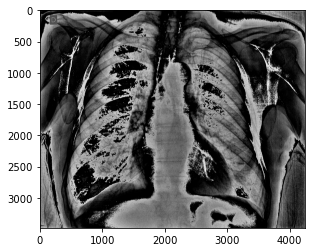

In [44]:
plt.imshow(im)

In [45]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))

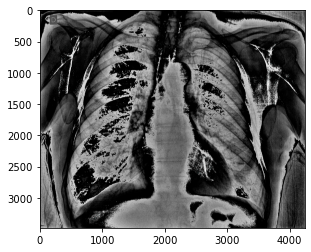

In [46]:
kp = sift.detect(im,None)
kp, des = sift.compute(im, kp)
img=draw_keypoints(im,kp)

In [47]:
for image_pat in image_paths:
    im=cv2.imread(image_pat)
    kp=sift.detect(im,None)
    keypoints,descriptor= sift.compute(im, kp)
    des_list.append((image_pat,descriptor))

In [48]:
descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))

In [49]:
descriptors.shape

(227956, 128)

In [50]:
descriptors_float=descriptors.astype(float)

In [51]:
from scipy.cluster.vq import kmeans,vq

In [52]:
k=200
voc,variance=kmeans(descriptors_float,k,1)

In [53]:
im_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1

In [54]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

In [55]:
des_list_test=[]

In [56]:
for image_pat in image_paths_test:
    image=cv2.imread(image_pat)
    kp=sift.detect(image,None)
    keypoints_test,descriptor_test= sift.compute(image, kp)
    des_list_test.append((image_pat,descriptor_test))

In [57]:
from scipy.cluster.vq import vq
test_features=np.zeros((len(image_paths_test),k),"float32")
for i in range(len(image_paths_test)):
    words,distance=vq(des_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1

ValueError: object arrays are not supported

In [ ]:
test_features

In [ ]:
test_features=stdslr.transform(test_features)

In [ ]:
y_test

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.metrics import accuracy_score
clf = xgb.XGBClassifier()
clf.fit(im_features,np.array(y_train))

In [ ]:
y_pred=clf.predict(test_features)

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
print(accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import SGDClassifier

In [ ]:
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(im_features,np.array(y_train))

In [ ]:
y_pred=clf.predict(test_features)

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
print(accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))